<a href="https://colab.research.google.com/github/haripriyathati/trafuck/blob/main/crazzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
path = '/content/drive/MyDrive/Dataset'
labelFile = 'labels.csv'
batch_size_val=32
epochs_val=10
imageDimesions = (32,32,3)
testRatio = 0.2
validationRatio = 0.2

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [20]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)


print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes
Train(22272, 32, 32, 3) (22272,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [21]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

num_of_samples = []
cols = 5
num_classes = noOfClasses

data shape  (58, 2) <class 'pandas.core.frame.DataFrame'>


In [22]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [23]:
# 1. Image Preprocessing & Reshape (as before)
X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

# 2. **FIXED:** Label Preprocessing (One-Hot Encoding) MOVED UP
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses) # This is where y_train should be processed

# 3. Data Augmentation Setup (now using the correctly shaped y_train)
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

# The following lines are ONLY for testing/visualization, now they use the correct y_train
batches = dataGen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)


In [24]:
def myModel():
    model= Sequential()
    model.add((Conv2D(60,(5,5),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(60, (5,5), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add((Conv2D(30, (3,3),activation='relu')))
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [26]:
model = myModel()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
print(model.summary())
history=model.fit(dataGen.flow(X_train,y_train,batch_size=batch_size_val),
                  steps_per_epoch=len(X_train)//32,
                  epochs=epochs_val,
                  validation_data=(X_validation,y_validation),
                  shuffle=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


696/696 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.1675 - loss: 3.0976 - val_accuracy: 0.7340 - val_loss: 0.8581
Epoch 2/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5643 - loss: 1.4361 - val_accuracy: 0.9005 - val_loss: 0.3985
Epoch 3/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6951 - loss: 0.9913 - val_accuracy: 0.9492 - val_loss: 0.2184
Epoch 4/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7722 - loss: 0.7478 - val_accuracy: 0.9361 - val_loss: 0.2303
Epoch 5/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8107 - loss: 0.6246 - val_accuracy: 0.9680 - val_loss: 0.1279
Epoch 6/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8361 - loss: 0.5267 - val_accuracy: 0.9731 - val_loss: 0.1046
Epoch 7/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8597 - loss: 0.4502 - val_accuracy: 0.9772 - val_loss: 0.0733
Epoch 8/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8722 - loss: 0.4100 - val_accurac

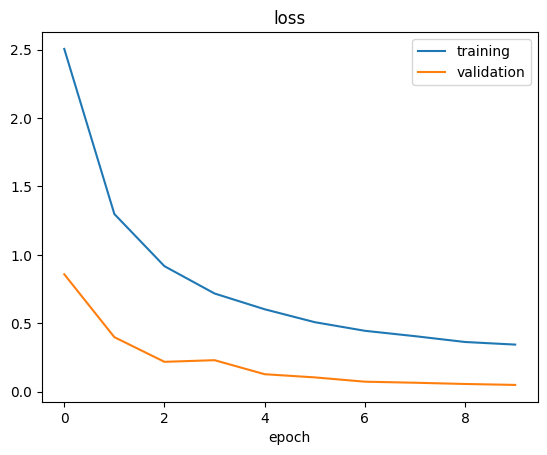

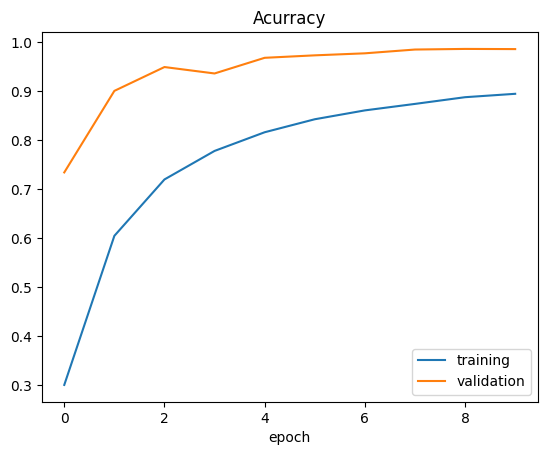

Test Score: 0.047881271690130234
Test Accuracy: 0.9866379499435425


In [28]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

model.save("model.h5")